In [1]:
from pathlib import PurePath
import os
import sys
os.chdir(PurePath(os.path.abspath('')).parent)
sys.path.append(os.getcwd())

In [2]:
import numpy as np
import igraph as ig
import leidenalg
import pandas as pd
import matplotlib.pyplot as plt
from qmap.toolkit import aligner
import torch

from split_utils import read_fasta, Identity, compute_identity_stats

/Users/anthonylavertu/mac_docs/pycharmProjects/QMAP/split_experiment/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
THRESHOLD = 0.55
MIN_SEQ_LEN = 5
MAX_SEQ_LEN = 50

# Load data

In [24]:
dm = np.load(f".cache/identity_matrix.npy")
with open(f".cache/row_ids.txt", 'r') as f:
    dm_ids = np.array([int(id_) for id_ in f.readlines()])

dataset = read_fasta("../data/build/dataset.fasta")
dataset = {int(id_): seq for id_, seq in dataset}

# Filter like for the other experiments
mask = np.array([MIN_SEQ_LEN <= len(dataset[id_]) <= MAX_SEQ_LEN for id_ in dm_ids])
dm = dm[mask][:, mask]  # Filter the distance matrix
dm_ids = dm_ids[mask]  # Filter the IDs accordingly

In [5]:
# Now, compute the pseudo-distance matrix
data = {key: value for key, value in dataset.items() if MIN_SEQ_LEN <= len(value) <= MAX_SEQ_LEN}
ids, sequences = zip(*data.items())

In [6]:
encoder = aligner.Encoder(force_cpu=True)
vectorDB = encoder.encode(sequences)
alignments = aligner.align_db(vectorDB, vectorDB, device="cpu").alignment_matrix

Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  36/36 it 0.53 it/s eta 00:00


In [7]:
# Now, compare the pseudo-alignments with the true alignments
error = np.abs(alignments - dm)
mean_difference = np.mean(error)
label = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
quantiles = np.quantile(error, label)
print(f"Mean difference between pseudo-alignments and true alignments: {mean_difference}")
print("Quantiles of the error:")
for q, val in zip(label, quantiles):
    print(f"- {q:.2f} quantile: {val}")

Mean difference between pseudo-alignments and true alignments: 0.03988019130342848
Quantiles of the error:
- 0.05 quantile: 0.0027888371394230727
- 0.10 quantile: 0.0056396484375000056
- 0.25 quantile: 0.014572870163690466
- 0.50 quantile: 0.03178325452302633
- 0.75 quantile: 0.056398589035560345
- 0.90 quantile: 0.0849609375
- 0.95 quantile: 0.10506663602941174
- 0.99 quantile: 0.14876302083333334


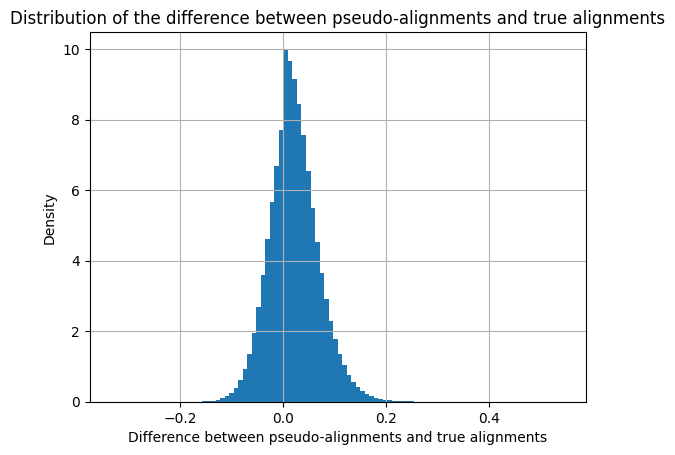

In [10]:
# Plot a figure of the error distribution
flatten_align = alignments.reshape(-1)
flatten_targets = dm.reshape(-1)
error = flatten_align - flatten_targets
# mid_iden_error = error[np.logical_and(flatten_targets > 0.4, flatten_targets < 0.6)]
plt.hist(error, bins=100, density=True)
plt.xlabel("Difference between pseudo-alignments and true alignments")
plt.ylabel("Density")
plt.title("Distribution of the difference between pseudo-alignments and true alignments")
plt.grid()

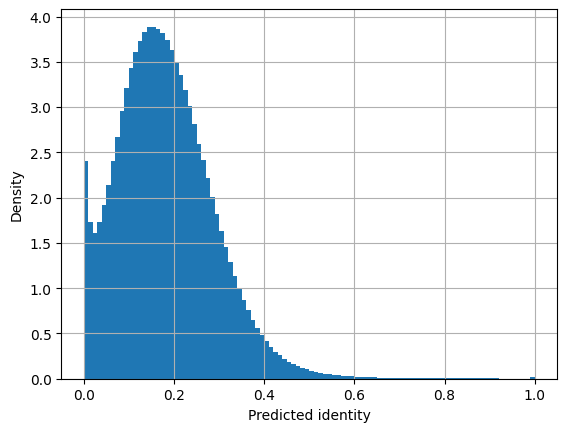

In [11]:
# Plot a figure of the error distribution

plt.hist(alignments.reshape(-1), bins=100, density=True)
plt.xlabel("Predicted identity")
plt.ylabel("Density")
plt.grid()

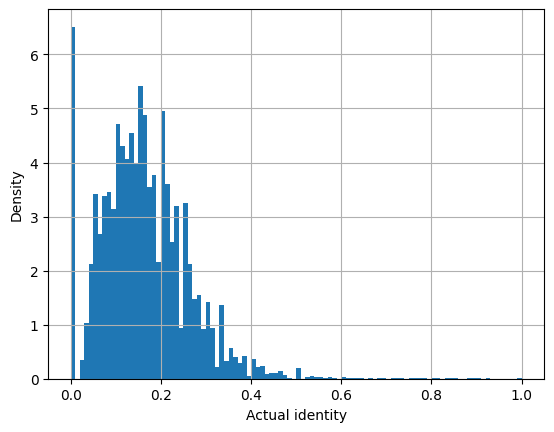

In [12]:
plt.hist(dm.reshape(-1), bins=100, density=True)
plt.xlabel("Actual identity")
plt.ylabel("Density")
plt.grid()

In [14]:
# Visualize worst cases
error = np.abs(alignments - dm)
worst_cases = np.argsort(error, axis=None)[-50:]  # Get indices of the worst cases
worst_cases = np.unravel_index(worst_cases, error.shape)
worst_cases = [(i, j) for i, j in zip(*worst_cases) if i < j]  # Keep only upper triangle indices
print("Worst cases (IDs):")
print_seqs = set()
for i, j in worst_cases:
    i_id = dm_ids[i]
    j_id = dm_ids[j]
    seq1 = dataset[i_id]
    seq2 = dataset[j_id]
    if (seq1, seq2) in print_seqs or (seq2, seq1) in print_seqs:
        continue  # Avoid duplicates
    print_seqs.add((seq1, seq2))
    print(f"- {seq1} vs {seq2} with error {error[i, j]:.4f}; pseudo-id: {alignments[i, j]:.4f}, true-id: {dm[i, j]:.4f}")

Worst cases (IDs):
- KRKIL vs RKWWK with error 0.4504; pseudo-id: 0.4504, true-id: 0.0000
- QRXLRXG vs AXLXXLX with error 0.4504; pseudo-id: 0.4504, true-id: 0.0000
- KRKIKRK vs RKKTRKR with error 0.4509; pseudo-id: 0.5938, true-id: 0.1429
- QKKIRVRASA vs LCRVHKKIAI with error 0.4521; pseudo-id: 0.4521, true-id: 0.0000
- XYXYXYXYXYXY vs KXKXKXKXKXKX with error 0.4524; pseudo-id: 0.4524, true-id: 0.0000
- TRXLRXG vs AXLXXLX with error 0.4543; pseudo-id: 0.4543, true-id: 0.0000
- XRXLRXG vs AXLXXLX with error 0.4568; pseudo-id: 0.4568, true-id: 0.0000
- RKWLFW vs KRKILI with error 0.4602; pseudo-id: 0.4602, true-id: 0.0000
- KRKGKRK vs RKKTRKR with error 0.4607; pseudo-id: 0.6035, true-id: 0.1429
- XXSXG vs LSXFI with error 0.4641; pseudo-id: 0.4641, true-id: 0.0000
- PRXLRXG vs AXLXXLX with error 0.4675; pseudo-id: 0.4675, true-id: 0.0000
- RKDVY vs KDEKK with error 0.4683; pseudo-id: 0.4683, true-id: 0.0000
- XFXFXFXFXFXFXFXF vs KXKXKXKXKXKXKXKX with error 0.4700; pseudo-id: 0.4700, tr

# Create graph

In [13]:
adjacency_matrix = (alignments > THRESHOLD).astype(int)

# Make edge list from adjacency matrix
edge_list = []
for i in range(adjacency_matrix.shape[0]):
    for j in range(i + 1, adjacency_matrix.shape[1]):  # only upper triangle for undirected
        if adjacency_matrix[i, j] == 1:
            edge_list.append((i, j))
nodeidx2id = {i: dm_ids[i] for i in range(len(dm_ids))}
if not os.path.exists(".cache/deepheuristic"):
    os.makedirs(".cache/deepheuristic")

# Create edgelist file
with open(".cache/deepheuristic/graph.edgelist", 'w') as f:
    for i, j in edge_list:
        f.write(f"{i}\t{j}\n")

# Load graph
g = ig.Graph.Read_Edgelist(".cache/deepheuristic/graph.edgelist", directed=False)

# Find communities using Leiden algorithm

In [14]:
partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition, n_iterations=-1)

# Now, make dataframe with communities
df = {"node_id": [], "community": []}
for i, comm in enumerate(partition):
    for node in comm:
        df["node_id"].append(nodeidx2id[node])
        df["community"].append(i)


df = pd.DataFrame(df)

# Split clusters into two sets

In [15]:
# Now split the dataset into communities
def split_clusters(clusters, test_ratio: float = 0.2):
    """
    Splits the clusters into training and test sets based on a given test ratio.
    :param clusters: The clusters DataFrame containing sequence IDs and their corresponding cluster IDs.
    :param test_ratio: The ratio of sequences to be included in the test set.
    :return: Two sets of ids, one for training and one for testing.
    """
    cluster_ids = clusters['community'].unique()
    print(f"Found {len(cluster_ids)} clusters in the dataset.")
    # Clusters are ordered by size, so we can just take the last n_test clusters in order to maximize the diversity
    # Compute the cumsum of the cluster sizes
    cluster_sizes = clusters['community'].value_counts().sort_index()
    cum_sum = cluster_sizes.cumsum()
    n_train = int(len(clusters) * (1 - test_ratio))
    train_mask = cum_sum <= n_train
    train_clusters = cluster_sizes[train_mask].index.tolist()
    test_clusters = cluster_sizes[~train_mask].index.tolist()
    train_ids = clusters[clusters['community'].isin(train_clusters)]['node_id'].tolist()
    test_ids = clusters[clusters['community'].isin(test_clusters)]['node_id'].tolist()
    return train_ids, test_ids

train_ids, test_ids = split_clusters(df)

Found 1553 clusters in the dataset.


# Assert independence between training and test sets

In [16]:
identity_calculator = Identity()

identities, true_train_set = compute_identity_stats(train_ids, test_ids, identity_calculator=identity_calculator)
if np.isnan(identities).any():
    print("Warning: There are NaN values in the identities array. This may indicate missing data for some sequences.")

 100%|█████████████████████████████████████|  3626/3626 [00:09<00:00, 49.78it/s] 


In [17]:
test2train_id = identities.max(axis=1)

Max identity: 0.8888888888888888
Mean identity: 0.43116043437521145
Median identity: 0.42857142857142855
Quantiles:
- 0.01 quantile: 0.3
- 0.05 quantile: 0.32608695652173914
- 0.10 quantile: 0.34375
- 0.25 quantile: 0.38461538461538464
- 0.50 quantile: 0.42857142857142855
- 0.75 quantile: 0.47058823529411764
- 0.90 quantile: 0.5217391304347826
- 0.95 quantile: 0.5555555555555556
- 0.99 quantile: 0.625
Number of sequences in the training set that are not similar to any test sequence (identity > 0.5):
13173


Text(0.5, 1.0, 'Highest identity between each test sequence and all train sequences')

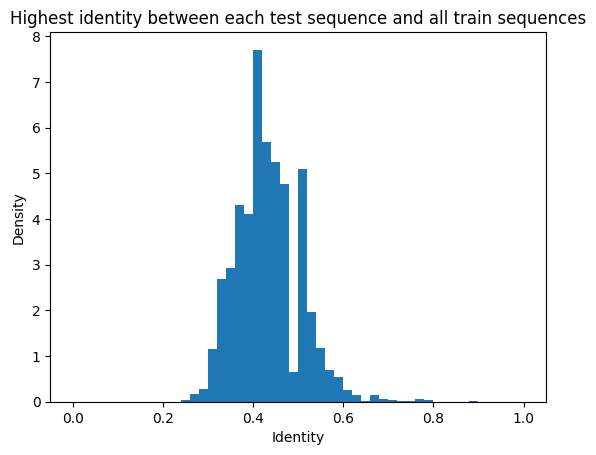

In [18]:
print(f"Max identity: {np.max(test2train_id)}")
print(f"Mean identity: {np.mean(test2train_id)}")
print(f"Median identity: {np.median(test2train_id)}")
print("Quantiles:")
for q in [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]:
    print(f"- {q:.2f} quantile: {np.quantile(test2train_id, q)}")

print("Number of sequences in the training set that are not similar to any test sequence (identity > 0.5):")
print(np.sum(true_train_set))
plt.hist(test2train_id, bins=50, range=(0, 1), density=True)
plt.xlabel("Identity")
plt.ylabel("Density")
plt.title("Highest identity between each test sequence and all train sequences")

Text(0.5, 1.0, 'Pairwise identity distribution between train and test')

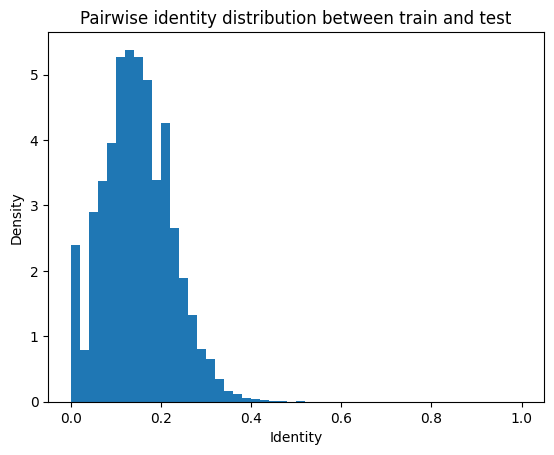

In [19]:
plt.hist(identities.reshape(-1), bins=50, range=(0, 1), density=True)
plt.xlabel("Identity")
plt.ylabel("Density")
plt.title("Pairwise identity distribution between train and test")

In [20]:
print(f"Length of train dataset: {len(train_ids)}")

Length of train dataset: 14309


# Test the random split

In [25]:
from qmap.toolkit import split

train_seq, test_seq, train_ids, test_ids = split.train_test_split(
    sequences,
    ids,
    test_size=0.2,
    post_filtering=True,
    threshold=THRESHOLD)

Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  36/36 it 0.56 it/s eta 00:00
Found 1553 clusters in the dataset.
Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  8/8 it 0.52 it/s eta 00:00
Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  29/29 it 0.54 it/s eta 00:00


In [26]:
identity_calculator = Identity()

identities, true_train_set = compute_identity_stats(train_ids, test_ids, identity_calculator=identity_calculator)
if np.isnan(identities).any():
    print("Warning: There are NaN values in the identities array. This may indicate missing data for some sequences.")

 100%|████████████████████████████████████|  3597/3597 [00:10<00:00, 184.06it/s] 


In [27]:
test2train_id = identities.max(axis=1)

Max identity: 0.6666666666666666
Mean identity: 0.4627896114818143
Median identity: 0.46153846153846156
Quantiles:
- 0.01 quantile: 0.3333333333333333
- 0.05 quantile: 0.375
- 0.10 quantile: 0.4
- 0.25 quantile: 0.42857142857142855
- 0.50 quantile: 0.46153846153846156
- 0.75 quantile: 0.5
- 0.90 quantile: 0.5333333333333333
- 0.95 quantile: 0.55
- 0.99 quantile: 0.6
Number of sequences in the training set that are not similar to any test sequence (identity > 0.5):
11259


Text(0.5, 1.0, 'Highest identity between each test sequence and all train sequences')

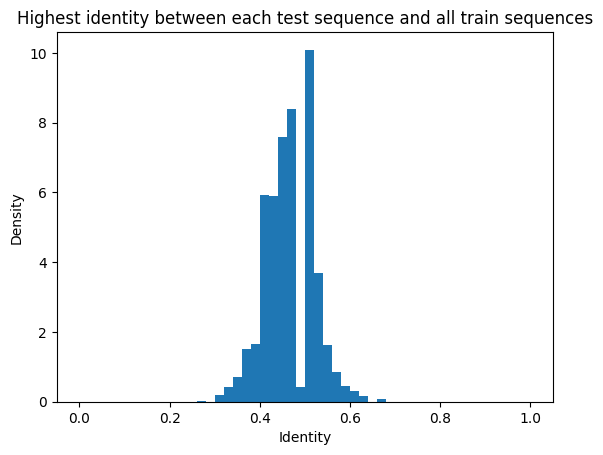

In [28]:
print(f"Max identity: {np.max(test2train_id)}")
print(f"Mean identity: {np.mean(test2train_id)}")
print(f"Median identity: {np.median(test2train_id)}")
print("Quantiles:")
for q in [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]:
    print(f"- {q:.2f} quantile: {np.quantile(test2train_id, q)}")

print("Number of sequences in the training set that are not similar to any test sequence (identity > 0.5):")
print(np.sum(true_train_set))
plt.hist(test2train_id, bins=50, range=(0, 1), density=True)
plt.xlabel("Identity")
plt.ylabel("Density")
plt.title("Highest identity between each test sequence and all train sequences")

In [29]:
len(train_seq) # + len(test_seq)

12328

In [21]:
(identities.T > 0.55).any(axis=1).sum()

np.int64(2332)

In [22]:
identities.shape

(3721, 14214)